# 14b. Green signal peak separator U1313
The color analysis outputs the percent of pixels at a given depth which are green. The question is: What meaning does this percent green have? Is it actually meaningful on its own? The current plan is to set a threshold for a percent green-ness that will constitute a binary positive confirmation of a green layer. 

## Setup
### Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from scipy import signal,interpolate,stats,linalg
from IPython.display import clear_output
import time
import numpy as np
import seaborn as sns
from PIL import Image
import os
import cv2 as cv
import pickle
import random

### File Paths

In [2]:
data_path='/Users/danielbabin/GitHub/Green_Bands/Data/'
table_path='/Users/danielbabin/GitHub/Green_Bands/Tables/'
core_photos='/Volumes/SanDisk.Data/IODP1313CorePhotos/'
section_path='/Volumes/SanDisk.Data/IODP1313CorePhotos/Cropped/'
lowres='/Volumes/SanDisk.Data/IODP1313CorePhotos/LowRes/Raw/'
lowres_filtered='/Volumes/SanDisk.Data/IODP1313CorePhotos/LowRes/Raw/'
filtered_path='/Volumes/SanDisk.Data/IODP1313CorePhotos/Filtered/'
figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Main/'
sup_figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Supplementary/'
checkpoints_path='/Users/danielbabin/GitHub/Green_Bands/Data/Checkpoints/'

### Import Green Splice

In [27]:
green=pd.read_csv(table_path+'Supplementary Table 5B - U1313 green intensity splice.csv',
                  index_col='CCSF Depth (m)')
green['SectionLabel']=(green['Site'].map(str)+green['Hole']+'_'+
                       green['Core'].map(str)+green['Type']+
                       green['Section'].map(str))
green=green[green.index.duplicated()==False]
green=green.sort_index()
green_channel_cols=green.columns[7:-1]
green.loc[green['Green%']<=1,'Green%']=0
green=green.loc[:56].copy()

### Import splice data

In [40]:
splice=pd.read_csv(data_path+'SpliceTables/cleanSpliceConstruction1313.csv')
splice['CoreLabel']=(splice['Site'].map(str).str.strip()+splice['Hole'].str.strip()+'_'+splice['Core'].map(str))

section_list=pd.read_csv(data_path+'SectionSummaries/spliceSections1313.csv')
section_list['SectionLabel']=(section_list['Site'].map(str)+section_list['Hole']+'_'+
                              section_list['Core'].map(str)+section_list['Type']+
                              section_list['Section'].map(str))
section_list=section_list.set_index('SectionLabel',drop=False)
section_list=section_list[(section_list['Top(mcd)']>0)&(section_list['Top(mcd)']<56)&
                      (section_list['Section']!='CC')]

In [41]:
sections=section_list['SectionLabel'].reset_index(drop=True)

## Import core photos
(Full Resoluiton)

In [42]:
raws={}
filts={}
start=time.time()
for i,file in enumerate(section_list['Filename'].iloc[:len(sections)]):
    clear_output(wait=True)
    section_label=section_list.index[i]
    handle=sections[i]
    raws[handle] = Image.open(section_path+file)
    filts[handle] = Image.open(filtered_path+file)
    
    stop=time.time()-start
    if i/len(section_list)*100<2:
        expected_time='Calculating...'
    else:
        expected_time=np.round((stop-0)/(i/len(section_list))/60,2)
    print('Current progress: ',np.round(i/len(section_list)*100,2),'%')
    print('Current run time: ',np.round((stop-0)/60,2),' minutes')
    print('Expected run time: ',expected_time,' minutes')

Current progress:  97.78 %
Current run time:  0.0  minutes
Expected run time:  0.0  minutes


In [43]:
aspects=[]
for i,sect in enumerate(sections):
    shp=raws[sect].size
    aspects.append(shp[0]/shp[1])
aspects=np.array(aspects)
naspests=((16.6/aspects)-1)/2

## Find Green Layers
### Find Peaks

In [44]:
peaks,md_peaks=signal.find_peaks(green['Green%'],prominence=7,distance=10)
depths_peaks=green.iloc[peaks]['Green%']
widths=signal.peak_widths(green['Green%'],peaks,rel_height=.95)
peaks=depths_peaks.to_frame(name='Green%')
peaks['Widths']=widths[0]
peaks['Prominence']=md_peaks['prominences']
peaks['Widths Height']=widths[1]
peaks['Left IP']=widths[2]
peaks['Right IP']=widths[3]
left_depth=green.iloc[peaks['Left IP']].index
right_depth=green.iloc[peaks['Right IP']].index
peaks['Left Depth']=left_depth
peaks['Right Depth']=right_depth

### Parse groups of peaks

In [45]:
peaks['Super Peak']=False
peaks['Real Left']=peaks['Left Depth']
peaks['Real Right']=peaks['Right Depth']
for i in peaks.index:
    lb=peaks.loc[i,'Left Depth']
    rb=peaks.loc[i,'Right Depth'] 
    l_trues=peaks['Left Depth'].between(left=lb,right=rb,inclusive='neither')
    l_test=l_trues.any() ## is anything's left depth between?
    r_trues=peaks['Right Depth'].between(left=lb,right=rb,inclusive='neither')
    r_test=r_trues.any() ## is anything's right depth between
    if l_test&r_test==True:
        peaks.loc[i,'Super Peak']=True
        trueids=pd.concat([peaks[l_trues],peaks[r_trues]]).sort_index().index
        
        lt_peak_center=trueids<i
        if lt_peak_center.any()==True:
            left_id=np.where(lt_peak_center==True)[0][-1]
            peaks.loc[i,'Real Left']=peaks.loc[trueids[left_id],'Right Depth']+.001
        else:
            peaks.loc[i,'Left Depth']=peaks.loc[i,'Left Depth']
            
        gt_peak_center=trueids>i
        if gt_peak_center.any()==True:
            right_id=np.where(gt_peak_center==True)[0][0]
            peaks.loc[i,'Real Right']=peaks.loc[trueids[right_id],'Left Depth']-.001
        else:
            peaks.loc[i,'Right Depth']=peaks.loc[i,'Right Depth']
            
    elif (l_test==True)&(r_test==False):
        peaks.loc[i,'Real Right']=peaks.shift(-1).loc[i,'Left Depth']
    elif (r_test==True)&(l_test==False):
        peaks.loc[i,'Real Left']=peaks.shift(1).loc[i,'Right Depth'].copy()
peaks['Real Width Depth']=peaks['Real Right']-peaks['Real Left']
peaks.loc[peaks['Real Width Depth']==0,'Real Width Depth']=.001

#### Mark duplicates
Some peaks oddly have different peaks, but identical tops and bottoms.

In [46]:
top_not_duplicated=peaks.reset_index().groupby('Real Left').first()['CCSF Depth (m)']
peaks['Top Duplicated']=True
peaks.loc[top_not_duplicated,'Top Duplicated']=False

In [47]:
peaks_tops_not_dup=peaks[peaks['Top Duplicated']==False].copy()

bottoms_not_duplicated=peaks_tops_not_dup.reset_index().groupby('Real Right').last()['CCSF Depth (m)']
peaks_tops_not_dup['Bottom Duplicated']=True
peaks_tops_not_dup.loc[bottoms_not_duplicated,'Bottom Duplicated']=False

In [48]:
peaks['Bottom Duplicated']=peaks['Top Duplicated']
peaks.loc[peaks_tops_not_dup[peaks_tops_not_dup['Bottom Duplicated']==True].index,'Bottom Duplicated']=True

In [49]:
peaks['Duplicated']=peaks['Bottom Duplicated']|peaks['Top Duplicated']

### Quality control check

In [54]:
n=13
sect=sections[n]
dmin=section_list.loc[sections[n],'Top(mcd)']
dmax=section_list.loc[sections[n],'Bottom(mcd)']
splice_dmin=green[green['SectionLabel']==sections[n]].index[0]
splice_dmax=green[green['SectionLabel']==sections[n]].index[-1]
slc_peaks=peaks.loc[splice_dmin:splice_dmax].copy()
sect_img_raw=raws[sect]
sect_img_filt=filts[sect]
data=green.loc[green['SectionLabel']==sections[n],'Green%']

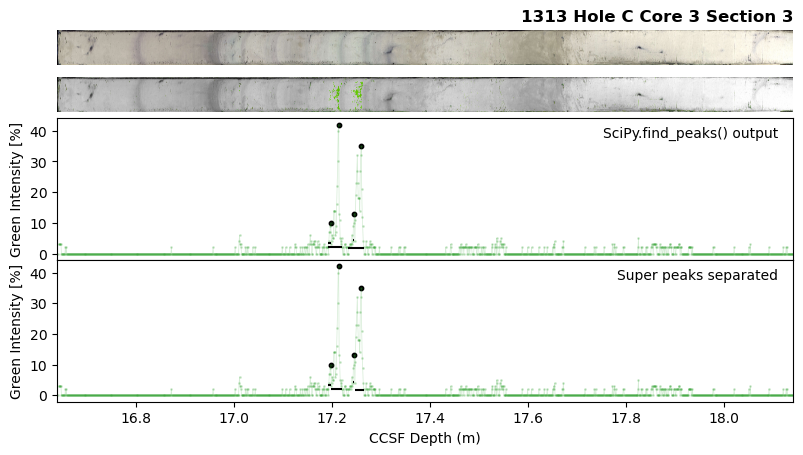

In [55]:
fig=plt.figure(figsize=(8,4.5))
gs = gridspec.GridSpec(8, 1, figure=fig,hspace=0,left=.07,right=.99,top=.95,bottom=.11)
ax1=fig.add_subplot(gs[0,:])
ax2=fig.add_subplot(gs[1,:])
ax3=fig.add_subplot(gs[2:5,:])
ax4=fig.add_subplot(gs[5:8,:])

ax1.imshow(sect_img_raw)
ax1.axis('off');
ax1.set_title(sect[:4]+' Hole '+sect[4]+' Core '+sect[6]+' Section '+sect[-1],fontweight='bold',loc='right')

ax2.imshow(sect_img_filt)
ax2.axis('off');

ax=ax3
data.plot(color='tab:green',marker='o',ms=1,lw=.5,ax=ax,alpha=.2)
ax.scatter(slc_peaks.index,slc_peaks['Green%'],color='k',s=10)
ax.hlines(slc_peaks['Widths Height'],xmin=slc_peaks['Left Depth'],xmax=slc_peaks['Right Depth'],color='k')
ax.set_xlim(dmin,dmax)

ax=ax4
data.plot(color='tab:green',marker='o',ms=1,lw=.5,ax=ax,alpha=.2)
ax.scatter(slc_peaks.index,slc_peaks['Green%'],color='k',s=10)
ax.hlines(slc_peaks['Widths Height'],xmin=slc_peaks['Real Left'],xmax=slc_peaks['Real Right'],color='k')
ax.set_xlim(dmin,dmax)

steps=['SciPy.find_peaks() output','Super peaks separated']
for i,ax in enumerate([ax3,ax4]):
    ax.set_ylabel('Green Intensity [%]')
    ax.annotate(steps[i],xy=(.98,.94),xycoords='axes fraction',ha='right',va='top')

# fig.savefig(sup_figure_path+'Sup Figure 14 Green Super Peak Separation.png',dpi=500)

### Make green layers table

In [56]:
green_layers=peaks[['Real Left','Real Right','Real Width Depth','Duplicated']].copy()
green_layers=green_layers[green_layers['Duplicated']==False].copy()
green_layers['Real Width Depth']=green_layers['Real Width Depth']*100
green_layers=green_layers.rename(columns={'Real Left':'Top Depth CCSF (m)',
                                          'Real Right':'Bottom Depth CCSF (m)',
                                          'Real Width Depth':'Thickness (cm)'})

In [57]:
md_cols=['Exp', 'Site', 'Hole', 'Core', 'Type', 'Section']
green_layers[md_cols]=green.loc[green_layers.index,md_cols]
green_layers['Bottom Offset (cm)']=green.reindex(green_layers['Bottom Depth CCSF (m)'],
                                                 method='nearest')['Offset (cm)'].values
green_layers['Top Offset (cm)']=(green_layers['Bottom Offset (cm)']-green_layers['Thickness (cm)']).round(1)
green_layers=green_layers.reset_index()

In [58]:
keep_cols=['Exp', 'Site', 'Hole', 'Core','Type', 'Section',
           'Top Offset (cm)','Bottom Offset (cm)','Top Depth CCSF (m)',
           'Bottom Depth CCSF (m)','Thickness (cm)']
green_layers=green_layers[keep_cols]

## Randomize depth order of layers
Our plan is to pick 100 random measurements that came out as "Green" from step 05 and graph the %Green next to the core and input whether or not it really looks like a green layer. These datapoints collectively should help determine where the thresholdhold for %Green really is.  

In [62]:
greens=green_layers.copy()
greens['Label']=None
greens['N']=np.arange(len(greens))
greens=greens.sample(frac=1)
greens['N (new)']=np.arange(len(greens))
greens['SectionLabel']=(greens['Site'].map(str)+greens['Hole']+'_'+
                       greens['Core'].map(str)+greens['Type']+
                       greens['Section'].map(str))
greens.to_csv(checkpoints_path+'green.peak.labeling.U1313.csv',index=False)

In [63]:
# greens=pd.read_csv(checkpoints_path+'green.peak.labeling.U1313.csv',index_col='Top Depth CCSF (m)')